## Ranking Neural Net

In [339]:
import torch 
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
# import tensorboard
from torch.utils.tensorboard import SummaryWriter
from scipy.stats import pearsonr

In [340]:
class PrismDataset(Dataset):
    def __init__(self, response_df, feature_df, feature_importance_df, top_k_features, slate_length, quantile_transfomer=None, prioritize_sensitive=True):
        self.response_df = response_df
        self.feature_df = feature_df
        self.feature_importance_df = feature_importance_df
        self.top_k_features = top_k_features
        self.slate_length = slate_length
        self.prioritize_sensitive = prioritize_sensitive
        
        # Get the top k features based on importance
        self.top_features = self.feature_importance_df.nlargest(top_k_features, "importance")["feature"].tolist()

        # filter self.feature_df to include only the top features
        self.feature_df = self.feature_df.loc[:, self.top_features]

        # quantile transform all features
        if not quantile_transfomer:
            self.quantile_transfomer = PowerTransformer()
            self.quantile_transfomer.fit(self.feature_df)
        else:
            self.quantile_transfomer = quantile_transfomer

        # quantile transform feature_df
        self.feature_df = pd.DataFrame(self.quantile_transfomer.transform(self.feature_df), columns=self.feature_df.columns, index=self.feature_df.index)

        # quantile transform labels
        self.label_transformer = QuantileTransformer()
        self.response_df["LFC.cb"] = self.label_transformer.fit_transform(self.response_df[["LFC.cb"]])
        if self.prioritize_sensitive:
            self.response_df.loc[:, "LFC.cb"] = 1 - self.response_df.loc[:, "LFC.cb"]
        # scale from 0 to 5
        self.response_df.loc[:, "LFC.cb"] = self.response_df.loc[:, "LFC.cb"] * 5

        # Join response_df and feature_df on "ccle_name"
        self.joined_df = pd.merge(self.response_df, self.feature_df, on="ccle_name")
        # set index to "ccle_name"
        self.joined_df = self.joined_df.set_index("ccle_name")

        # Order the columns
        self.cols = self.top_features + ["LFC.cb"]
        self.joined_df = self.joined_df.loc[:, self.cols]

        # impute missing values
        self.joined_df = self.joined_df.fillna(-1)

        # get ccle_names
        self.ccle_names = self.joined_df.index.tolist()

        if len(self.ccle_names) < self.slate_length:
            self.slate_length = len(self.ccle_names)

    def __len__(self):
        return len(self.ccle_names)

    def __getitem__(self, idx):
        # get slate_length - 1 samples from ccle_names
        index_name = self.ccle_names[idx]
        ccle_names = np.random.choice(self.ccle_names, self.slate_length - 1, replace=False).tolist()
        
        # get [index_name, *ccle_names] from joined_df
        samples = self.joined_df.loc[[index_name] + ccle_names, :]
        
        # Extract features and labels from the samples
        features = torch.tensor(samples.iloc[:, :-1].values, dtype=torch.float32)
        labels = torch.tensor(samples.iloc[:, -1].values.squeeze(), dtype=torch.float32)

        return features, labels


In [341]:
feature_path = "../../tests/data/test_features/x-all.pkl"
response_path = "../../tests/data/test_responses.csv"
feature_importance_path = "../../tests/data/test_output/cv/zotarolimus_BRD-K46843573-001-01-9_2.5_all_feature_importances.csv"

In [342]:
import pickle
with open(feature_path, "rb") as f:
    feature_df = pickle.load(f)
# rename index as ccle_name
feature_df = feature_df.rename_axis("ccle_name")

In [343]:
response_df = pd.read_csv(response_path)

In [344]:
feature_importance_df = pd.read_csv(feature_importance_path)

In [345]:
ds = PrismDataset(response_df, feature_df, feature_importance_df, 100, 10)

n_quantiles (1000) is greater than the total number of samples (50). n_quantiles is set to n_samples.


In [346]:
ds[0]

(tensor([[ 1.4714,  1.3802, -0.2590, -0.4291,  0.0694,  0.3141,  0.8002,  0.1148,
          -0.3804, -0.4974],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000],
         [ 0.8584, -0.3793,  0.2892,  0.0631,  0.0881,  0.1156, -0.4406, -1.1399,
          -2.4891, -0.4974],
         [-1.2352,  0.9600, -0.8605, -0.2508, -1.0352, -0.5007,  0.5604,  0.3973,
           2.4312, -0.4974],
         [-0.0547, -1.3340, -0.7092,  0.9247, -0.0938, -1.3944,  0.0121, -0.6382,
          -0.0343, -0.4974],
         [ 0.4510, -0.9949,  1.6994,  0.4267, -2.2797,  0.0129,  2.2422,  1.8409,
           1.1940,  2.1505],
         [-0.0734, -0.7190, -0.0973,  0.9718, -0.5173,  0.1388, -1.2816, -0.2258,
           0.6783, -0.4974],
         [-0.9030,  1.5698,  0.1464, -1.1285,  0.7820, -0.1685, -0.3057,  0.3973,
           0.3033, -0.4974],
         [-0.2944,  0.4510,  1.9956, -1.4555,  0.2095,  0.6602,  0.0276,  0.8292,
          -0.1705, -0.4974],
 

In [347]:
import torch

PADDED_Y_VALUE = -1
DEFAULT_EPS = 1e-10


def lambdaLoss(y_pred, y_true, eps=DEFAULT_EPS, padded_value_indicator=PADDED_Y_VALUE, weighing_scheme=None, k=None, sigma=1., mu=10.,
               reduction="sum", reduction_log="binary"):
    """
    LambdaLoss framework for LTR losses implementations, introduced in "The LambdaLoss Framework for Ranking Metric Optimization".
    Contains implementations of different weighing schemes corresponding to e.g. LambdaRank or RankNet.
    :param y_pred: predictions from the model, shape [batch_size, slate_length]
    :param y_true: ground truth labels, shape [batch_size, slate_length]
    :param eps: epsilon value, used for numerical stability
    :param padded_value_indicator: an indicator of the y_true index containing a padded item, e.g. -1
    :param weighing_scheme: a string corresponding to a name of one of the weighing schemes
    :param k: rank at which the loss is truncated
    :param sigma: score difference weight used in the sigmoid function
    :param mu: optional weight used in NDCGLoss2++ weighing scheme
    :param reduction: losses reduction method, could be either a sum or a mean
    :param reduction_log: logarithm variant used prior to masking and loss reduction, either binary or natural
    :return: loss value, a torch.Tensor
    """
    device = y_pred.device
    y_pred = y_pred.clone()
    y_true = y_true.clone()

    padded_mask = y_true == padded_value_indicator
    y_pred[padded_mask] = float("-inf")
    y_true[padded_mask] = float("-inf")

    # Here we sort the true and predicted relevancy scores.
    y_pred_sorted, indices_pred = y_pred.sort(descending=True, dim=-1)
    y_true_sorted, _ = y_true.sort(descending=True, dim=-1)

    # After sorting, we can mask out the pairs of indices (i, j) containing index of a padded element.
    true_sorted_by_preds = torch.gather(y_true, dim=1, index=indices_pred)
    true_diffs = true_sorted_by_preds[:, :, None] - true_sorted_by_preds[:, None, :]
    padded_pairs_mask = torch.isfinite(true_diffs)

    if weighing_scheme != "ndcgLoss1_scheme":
        padded_pairs_mask = padded_pairs_mask & (true_diffs > 0)

    ndcg_at_k_mask = torch.zeros((y_pred.shape[1], y_pred.shape[1]), dtype=torch.bool, device=device)
    ndcg_at_k_mask[:k, :k] = 1

    # Here we clamp the -infs to get correct gains and ideal DCGs (maxDCGs)
    true_sorted_by_preds.clamp_(min=0.)
    y_true_sorted.clamp_(min=0.)

    # Here we find the gains, discounts and ideal DCGs per slate.
    pos_idxs = torch.arange(1, y_pred.shape[1] + 1).to(device)
    D = torch.log2(1. + pos_idxs.float())[None, :]
    maxDCGs = torch.sum(((torch.pow(2, y_true_sorted) - 1) / D)[:, :k], dim=-1).clamp(min=eps)
    G = (torch.pow(2, true_sorted_by_preds) - 1) / maxDCGs[:, None]

    # Here we apply appropriate weighing scheme - ndcgLoss1, ndcgLoss2, ndcgLoss2++ or no weights (=1.0)
    if weighing_scheme is None:
        weights = 1.
    else:
        weights = globals()[weighing_scheme](G, D, mu, true_sorted_by_preds)  # type: ignore

    # We are clamping the array entries to maintain correct backprop (log(0) and division by 0)
    scores_diffs = (y_pred_sorted[:, :, None] - y_pred_sorted[:, None, :]).clamp(min=-1e8, max=1e8)
    scores_diffs.masked_fill(torch.isnan(scores_diffs), 0.)
    weighted_probas = (torch.sigmoid(sigma * scores_diffs).clamp(min=eps) ** weights).clamp(min=eps)
    if reduction_log == "natural":
        losses = torch.log(weighted_probas)
    elif reduction_log == "binary":
        losses = torch.log2(weighted_probas)
    else:
        raise ValueError("Reduction logarithm base can be either natural or binary")

    if reduction == "sum":
        loss = -torch.sum(losses[padded_pairs_mask & ndcg_at_k_mask])
    elif reduction == "mean":
        loss = -torch.mean(losses[padded_pairs_mask & ndcg_at_k_mask])
    else:
        raise ValueError("Reduction method can be either sum or mean")

    return loss


def ndcgLoss1_scheme(G, D, *args):
    return (G / D)[:, :, None]


def ndcgLoss2_scheme(G, D, *args):
    pos_idxs = torch.arange(1, G.shape[1] + 1, device=G.device)
    delta_idxs = torch.abs(pos_idxs[:, None] - pos_idxs[None, :])
    deltas = torch.abs(torch.pow(torch.abs(D[0, delta_idxs - 1]), -1.) - torch.pow(torch.abs(D[0, delta_idxs]), -1.))
    deltas.diagonal().zero_()

    return deltas[None, :, :] * torch.abs(G[:, :, None] - G[:, None, :])


def lambdaRank_scheme(G, D, *args):
    return torch.abs(torch.pow(D[:, :, None], -1.) - torch.pow(D[:, None, :], -1.)) * torch.abs(G[:, :, None] - G[:, None, :])


def ndcgLoss2PP_scheme(G, D, *args):
    return args[0] * ndcgLoss2_scheme(G, D) + lambdaRank_scheme(G, D)


def rankNet_scheme(G, D, *args):
    return 1.


def rankNetWeightedByGTDiff_scheme(G, D, *args):
    return torch.abs(args[1][:, :, None] - args[1][:, None, :])


def rankNetWeightedByGTDiffPowed_scheme(G, D, *args):
    return torch.abs(torch.pow(args[1][:, :, None], 2) - torch.pow(args[1][:, None, :], 2))

In [348]:
import torch
import torch.nn as nn

class FeedForwardNet(nn.Module):
    def __init__(self, input_dim):
        super(FeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [349]:
model = FeedForwardNet(10)

In [350]:
# create a torch dataloader around the dataset
from torch.utils.data import DataLoader
dl = DataLoader(ds, batch_size=3, shuffle=True)

In [351]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [352]:
for epoch in range(10):
    for batch in dl:
        features, labels = batch
        pred_scores = model(features)
        loss = lambdaLoss(pred_scores.squeeze(), labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 10, loss.item()))

Epoch [1/10], Loss: 83.7350
Epoch [2/10], Loss: 77.0161
Epoch [3/10], Loss: 74.2184
Epoch [4/10], Loss: 66.5239
Epoch [5/10], Loss: 63.5489
Epoch [6/10], Loss: 64.7216
Epoch [7/10], Loss: 51.4670
Epoch [8/10], Loss: 59.7166
Epoch [9/10], Loss: 53.7766
Epoch [10/10], Loss: 51.0442


In [353]:
pred_scores.shape

torch.Size([2, 10, 1])

In [354]:
pred_scores

tensor([[[ 1.1860],
         [ 2.4874],
         [ 1.3602],
         [ 1.1860],
         [ 0.1891],
         [ 2.5484],
         [-1.0674],
         [-0.5478],
         [-0.6696],
         [ 1.1459]],

        [[ 1.1459],
         [ 1.1860],
         [ 2.4874],
         [-0.6522],
         [-0.0179],
         [ 0.1441],
         [ 0.9555],
         [ 4.3952],
         [-0.2660],
         [ 0.1891]]], grad_fn=<ViewBackward0>)

# Now do the same but train on the GPU with real data

In [355]:
feature_path = "/mnt/c/Users/nick/Desktop/corsello_lab/data/depmap_public-22q1-305b_v24/x-all.pkl"
response_path = "/mnt/c/Users/nick/Desktop/corsello_lab/data/depmap_repurposing/updated_responses/AMG-232.csv"
feature_importance_path = "/mnt/c/Users/nick/Desktop/corsello_lab/refract/notebooks/20230522_debug_weighted_models/data/baseline_rf/all/AMG-232_BRD-K64925568-001-01-8_2.5_all_feature_importances.csv"

In [356]:
import pickle
with open(feature_path, "rb") as f:
    feature_df = pickle.load(f)
# rename index as ccle_name
feature_df = feature_df.rename_axis("ccle_name")

In [357]:
response_df = pd.read_csv(response_path)

In [358]:
feature_importance_df = pd.read_csv(feature_importance_path)

In [359]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [360]:
from sklearn.model_selection import KFold

In [361]:
splitter = KFold(n_splits=5, shuffle=True, random_state=42)

In [362]:
# add tensorboard logging


all_preds = []
all_true = []

NUM_FEATURES = 1000
SLATE_LENGTH = 50
NUM_EPOCHS = 50
BATCH_SIZE = 256

# create summary writer
writer = SummaryWriter()

for i, (train_index, test_index) in enumerate(splitter.split(response_df)):
    print(f"Fold {i+1}")
    response_train = response_df.iloc[train_index, :].copy()
    response_test = response_df.iloc[test_index, :].copy()
    ds_train = PrismDataset(response_train, feature_df, feature_importance_df, NUM_FEATURES, SLATE_LENGTH)
    dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)

    model = FeedForwardNet(NUM_FEATURES)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(NUM_EPOCHS):
        for batch in dl_train:
            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)
            pred_scores = model(features).squeeze()
            loss = lambdaLoss(pred_scores, labels, weighing_scheme="lambdaRank_scheme")
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, NUM_EPOCHS, loss.item()))
        writer.add_scalar("Loss/train", loss.item(), epoch)


    train_preds = []
    train_true = []
    for ex in ds_train:
        f, l = ex
        pred = model(f.to(device))[0]
        train_preds.append(float(pred))
        train_true.append(float(l[0]))
    # compute pearsonr 
    train_pearsonr = pearsonr(train_preds, train_true)

    # test pred scores
    preds = []
    true = []
    ds_test = PrismDataset(response_test, feature_df, feature_importance_df, NUM_FEATURES, SLATE_LENGTH, quantile_transfomer=ds_train.quantile_transfomer)
    for ex in ds_test:
        f, l = ex
        pred = model(f.to(device))[0]
        preds.append(float(pred))
        true.append(float(l[0]))
    # compute pearsonr
    test_pearsonr = pearsonr(preds, true)
    writer.add_scalar("Pearsonr/train", train_pearsonr[0], i)
    writer.add_scalar("Pearsonr/test", test_pearsonr[0], i)

    # append to all preds
    all_preds.extend(preds)
    all_true.extend(true)

Fold 1


n_quantiles (1000) is greater than the total number of samples (447). n_quantiles is set to n_samples.


Epoch [1/50], Loss: 1902.4792
Epoch [2/50], Loss: 1488.2336
Epoch [3/50], Loss: 998.4606
Epoch [4/50], Loss: 671.9679
Epoch [5/50], Loss: 507.5835
Epoch [6/50], Loss: 409.0882
Epoch [7/50], Loss: 356.8562
Epoch [8/50], Loss: 302.2748
Epoch [9/50], Loss: 267.3059
Epoch [10/50], Loss: 248.5643
Epoch [11/50], Loss: 225.2048
Epoch [12/50], Loss: 204.7771
Epoch [13/50], Loss: 195.9507
Epoch [14/50], Loss: 169.2624
Epoch [15/50], Loss: 163.2707
Epoch [16/50], Loss: 154.7079
Epoch [17/50], Loss: 146.2099
Epoch [18/50], Loss: 130.1868
Epoch [19/50], Loss: 118.5852
Epoch [20/50], Loss: 111.5818
Epoch [21/50], Loss: 107.8012
Epoch [22/50], Loss: 107.6982
Epoch [23/50], Loss: 94.9110
Epoch [24/50], Loss: 96.6542
Epoch [25/50], Loss: 89.0928
Epoch [26/50], Loss: 83.9239
Epoch [27/50], Loss: 81.3064
Epoch [28/50], Loss: 78.4213
Epoch [29/50], Loss: 73.8633
Epoch [30/50], Loss: 71.1735
Epoch [31/50], Loss: 64.5723
Epoch [32/50], Loss: 60.4515
Epoch [33/50], Loss: 57.4912
Epoch [34/50], Loss: 58.2308

n_quantiles (1000) is greater than the total number of samples (112). n_quantiles is set to n_samples.


Fold 2


n_quantiles (1000) is greater than the total number of samples (447). n_quantiles is set to n_samples.


Epoch [1/50], Loss: 1867.4446
Epoch [2/50], Loss: 1295.1257
Epoch [3/50], Loss: 840.4673
Epoch [4/50], Loss: 533.6327
Epoch [5/50], Loss: 396.6432
Epoch [6/50], Loss: 312.8341
Epoch [7/50], Loss: 278.5717
Epoch [8/50], Loss: 253.2895
Epoch [9/50], Loss: 219.6324
Epoch [10/50], Loss: 206.2332
Epoch [11/50], Loss: 197.0900
Epoch [12/50], Loss: 178.9939
Epoch [13/50], Loss: 162.7427
Epoch [14/50], Loss: 156.4442
Epoch [15/50], Loss: 145.4230
Epoch [16/50], Loss: 125.9742
Epoch [17/50], Loss: 123.4132
Epoch [18/50], Loss: 118.5312
Epoch [19/50], Loss: 111.0149
Epoch [20/50], Loss: 104.3954
Epoch [21/50], Loss: 97.9120
Epoch [22/50], Loss: 93.7510
Epoch [23/50], Loss: 90.1515
Epoch [24/50], Loss: 85.4512
Epoch [25/50], Loss: 80.1674
Epoch [26/50], Loss: 79.2651
Epoch [27/50], Loss: 69.4472
Epoch [28/50], Loss: 70.9108
Epoch [29/50], Loss: 68.2029
Epoch [30/50], Loss: 66.4406
Epoch [31/50], Loss: 62.0176
Epoch [32/50], Loss: 60.4411
Epoch [33/50], Loss: 55.6233
Epoch [34/50], Loss: 54.4417
E

n_quantiles (1000) is greater than the total number of samples (112). n_quantiles is set to n_samples.


Fold 3


n_quantiles (1000) is greater than the total number of samples (447). n_quantiles is set to n_samples.


Epoch [1/50], Loss: 1961.2830
Epoch [2/50], Loss: 1628.8318
Epoch [3/50], Loss: 1150.3182
Epoch [4/50], Loss: 765.9973
Epoch [5/50], Loss: 544.6154
Epoch [6/50], Loss: 426.9452
Epoch [7/50], Loss: 361.3051
Epoch [8/50], Loss: 323.4401
Epoch [9/50], Loss: 282.8615
Epoch [10/50], Loss: 269.2475
Epoch [11/50], Loss: 236.5366
Epoch [12/50], Loss: 212.7722
Epoch [13/50], Loss: 184.9404
Epoch [14/50], Loss: 173.0493
Epoch [15/50], Loss: 168.7301
Epoch [16/50], Loss: 148.1085
Epoch [17/50], Loss: 143.7040
Epoch [18/50], Loss: 132.5027
Epoch [19/50], Loss: 121.5747
Epoch [20/50], Loss: 115.8512
Epoch [21/50], Loss: 113.9911
Epoch [22/50], Loss: 104.4304
Epoch [23/50], Loss: 100.0878
Epoch [24/50], Loss: 98.1798
Epoch [25/50], Loss: 88.4704
Epoch [26/50], Loss: 85.3926
Epoch [27/50], Loss: 80.8018
Epoch [28/50], Loss: 76.7713
Epoch [29/50], Loss: 70.0124
Epoch [30/50], Loss: 70.1985
Epoch [31/50], Loss: 70.7227
Epoch [32/50], Loss: 65.7736
Epoch [33/50], Loss: 61.7764
Epoch [34/50], Loss: 57.93

n_quantiles (1000) is greater than the total number of samples (112). n_quantiles is set to n_samples.


Fold 4


n_quantiles (1000) is greater than the total number of samples (447). n_quantiles is set to n_samples.


Epoch [1/50], Loss: 1872.0806
Epoch [2/50], Loss: 1504.8468
Epoch [3/50], Loss: 1074.1658
Epoch [4/50], Loss: 705.3162
Epoch [5/50], Loss: 513.7089
Epoch [6/50], Loss: 400.1346
Epoch [7/50], Loss: 358.2637
Epoch [8/50], Loss: 309.6370
Epoch [9/50], Loss: 296.3632
Epoch [10/50], Loss: 254.7115
Epoch [11/50], Loss: 233.0743
Epoch [12/50], Loss: 205.3704
Epoch [13/50], Loss: 187.9191
Epoch [14/50], Loss: 175.9607
Epoch [15/50], Loss: 167.8713
Epoch [16/50], Loss: 157.6629
Epoch [17/50], Loss: 145.3151
Epoch [18/50], Loss: 131.3767
Epoch [19/50], Loss: 130.1006
Epoch [20/50], Loss: 117.9157
Epoch [21/50], Loss: 112.7071
Epoch [22/50], Loss: 102.7788
Epoch [23/50], Loss: 101.7080
Epoch [24/50], Loss: 91.1322
Epoch [25/50], Loss: 94.4302
Epoch [26/50], Loss: 84.2598
Epoch [27/50], Loss: 82.3835
Epoch [28/50], Loss: 80.4131
Epoch [29/50], Loss: 73.7987
Epoch [30/50], Loss: 72.9818
Epoch [31/50], Loss: 68.2144
Epoch [32/50], Loss: 64.4177
Epoch [33/50], Loss: 60.6406
Epoch [34/50], Loss: 60.89

n_quantiles (1000) is greater than the total number of samples (112). n_quantiles is set to n_samples.


Fold 5


n_quantiles (1000) is greater than the total number of samples (448). n_quantiles is set to n_samples.


Epoch [1/50], Loss: 1915.3446
Epoch [2/50], Loss: 1425.9965
Epoch [3/50], Loss: 936.8922
Epoch [4/50], Loss: 644.6122
Epoch [5/50], Loss: 481.6199
Epoch [6/50], Loss: 389.2834
Epoch [7/50], Loss: 340.9587
Epoch [8/50], Loss: 298.7892
Epoch [9/50], Loss: 273.9911
Epoch [10/50], Loss: 253.3874
Epoch [11/50], Loss: 218.3663
Epoch [12/50], Loss: 205.9157
Epoch [13/50], Loss: 195.9019
Epoch [14/50], Loss: 176.1024
Epoch [15/50], Loss: 162.5779
Epoch [16/50], Loss: 156.1584
Epoch [17/50], Loss: 145.1168
Epoch [18/50], Loss: 136.4697
Epoch [19/50], Loss: 123.5622
Epoch [20/50], Loss: 121.7644
Epoch [21/50], Loss: 115.1978
Epoch [22/50], Loss: 111.6557
Epoch [23/50], Loss: 98.7580
Epoch [24/50], Loss: 95.7167
Epoch [25/50], Loss: 90.3159
Epoch [26/50], Loss: 85.1384
Epoch [27/50], Loss: 78.7013
Epoch [28/50], Loss: 81.2928
Epoch [29/50], Loss: 79.5840
Epoch [30/50], Loss: 76.7211
Epoch [31/50], Loss: 71.4021
Epoch [32/50], Loss: 68.4082
Epoch [33/50], Loss: 62.1643
Epoch [34/50], Loss: 63.8993

n_quantiles (1000) is greater than the total number of samples (111). n_quantiles is set to n_samples.


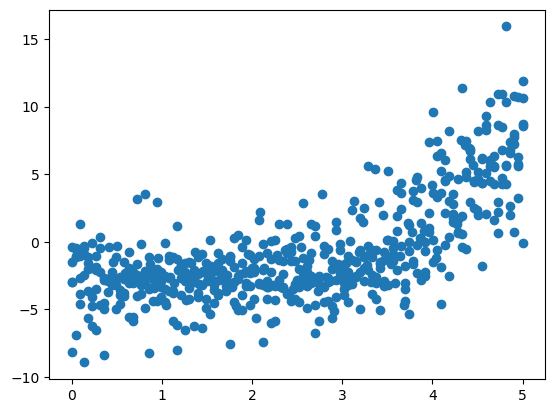

In [363]:
# plot all_preds vs all_true
import matplotlib.pyplot as plt
plt.scatter(all_true, all_preds)

In [364]:
# get pearson correlation all_preds vs all_true
from scipy.stats import pearsonr
pearsonr(all_true, all_preds)

(0.6671498729352686, 3.9638392983993463e-73)

In [396]:
df = pd.DataFrame({"preds": all_preds, "true": all_true})

In [400]:
df.head()
df["preds"] = QuantileTransformer().fit_transform(df[["preds"]]) * 5

n_quantiles (1000) is greater than the total number of samples (558). n_quantiles is set to n_samples.


In [406]:
# compute top 20 accuracy
def compute_accuracy_at_k(df, k_list=[1,5,10,20,50]):
    out = {}
    for k in k_list:
        df["preds_rank"] = df["preds"].rank(ascending=False)
        df["true_rank"] = df["true"].rank(ascending=False)

        df["preds_rank"] = df["preds_rank"].astype(int)
        df["true_rank"] = df["true_rank"].astype(int)

        df["top_true"] = df["true_rank"].apply(lambda x: 1 if x <= k else 0)
        df["top_pred"] = df["preds_rank"].apply(lambda x: 1 if x <= k else 0)
        out[k] = (df["top_pred"] & df["top_true"]).sum() / k
    return out

In [411]:
(df["top_pred"] & df["top_true"]).sum() / k

0.3

## SHAP explainer

In [381]:
# get some samples
X = []
y = []
for ex in ds_train:
    f, l = ex
    if l[0] > 4.5 or l[0] < 0.5:
        X.append(f[0,:])
        y.append(l[0])

In [382]:
X = torch.stack(X)

In [383]:
X = X.to(device)

In [384]:
X.shape

torch.Size([90, 1000])

In [385]:
# expand middle dim
#X = X.unsqueeze(1)

In [386]:
X.shape

torch.Size([90, 1000])

In [387]:
from shap import DeepExplainer

In [388]:
exp = DeepExplainer(model, X)

In [389]:
model(X).shape

torch.Size([90, 1])

In [390]:
shap_values = exp.shap_values(X)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [391]:
from shap import summary_plot

In [392]:
# get X as numpy array
X_np = X.cpu().numpy()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


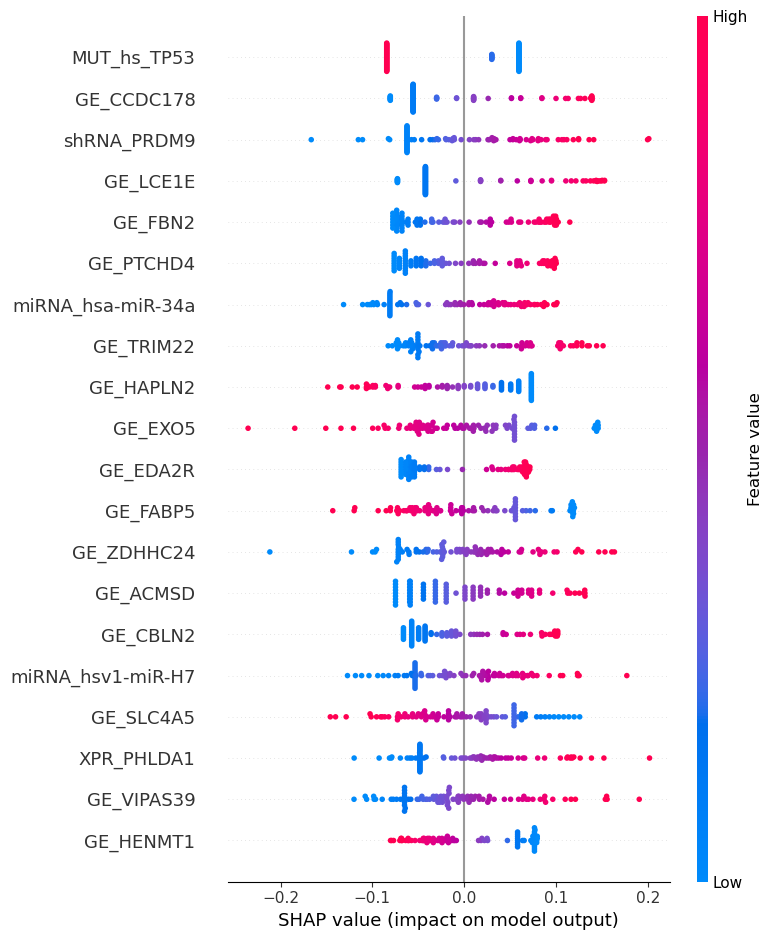

In [393]:
summary_plot(shap_values, X_np, feature_names=ds_train.joined_df.columns)